In [128]:
#%% Import all necessary libraries
import sys
sys.path.insert(0, '../modules')
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 10})
from sklearn.decomposition import PCA
import time
import napari
from matmatrix import consistentPCA, hullAnalysis, EuAngfromN
import os.path
import glob
import pickle
import msd
from scipy import stats, optimize
from dask.array import from_zarr
from skimage import measure
import cv2 
from naparimovie import Movie
import scipy.signal

# time settings in the light sheet
pxum = 0.115
camExposure_ms = 2
sweep_um = 20
stepsize_nm = 400
exp3D_ms = 1e-3 * camExposure_ms * (sweep_um*1e3/stepsize_nm) 
pxum = 0.115

In [144]:
# load raw images
this_file_dir = os.path.dirname(os.path.dirname(os.path.abspath("./")))
setName = "20220227_franky_MT_suc99_20um"
dataName = "timelapse_2022_02_28-03_03_30"
pathZarr = os.path.join(this_file_dir,
                        "DNA-Rotary-Motor", "Helical-nanotubes",
                        "Light-sheet-OPM", "Result-data",
                        setName, dataName, dataName+'-B.npy')
print(pathZarr)
stackRaw = np.array(da.from_npy_stack(pathZarr))

C:\Users\labuser\Dropbox (ASU)\Research\DNA-Rotary-Motor\Helical-nanotubes\Light-sheet-OPM\Result-data\20220227_franky_MT_suc99_20um\timelapse_2022_02_28-03_03_30\timelapse_2022_02_28-03_03_30-B.npy


In [145]:
# binarization, extract coordinates, and compute CM
blobBin = []
xb = []
# nt = len(stackRaw)
nt = 150
cm = np.zeros((nt,3))
n1s = np.zeros((nt, 3))
n2s = np.zeros((nt, 3))
n3s = np.zeros((nt, 3))
r_coms = np.zeros((nt, 3))
flagella_len = np.zeros(nt)
radial_dist_pt = np.zeros(nt)

for frame in range(nt):
# for frame in range(0,1):

    # threshold image
    thresvalue = 0.1
    img0 = stackRaw[frame]
    img0 = img0/max(img0.ravel())
    img = img0>thresvalue
    
    # threshold with median filter applied
#     img_now = np.array(stackRaw[frame])
#     img_now_med = scipy.signal.medfilt(img_now, kernel_size=(3,3,3)) # median filter image    
#     img = img_now_med > 0.85 * np.max(img_now_med) # threshold image
    
    # label each pixels for each clusters
    blobs = np.uint8(measure.label(img, background=0))
    
    # close holes
#     kernel = np.ones((6,6), np.uint8); 
#     blobs = cv2.morphologyEx(blobs, cv2.MORPH_CLOSE, kernel, iterations=1)

    # select largest
    if frame == 0:  # pick the largest for the 
        labels = np.unique(blobs.ravel())[1:] # spit out label numbers/tags
        sizes = np.array([np.argwhere(blobs==l).shape[0] for l in labels])
        keep = labels[np.argwhere((sizes == max(sizes)))[0]]
        blob = blobs == keep
        
        # constraint for the next frame with CM location
        X_f0 = np.argwhere(blob).astype('float')
        CM_f0 = np.array([sum(X_f0[:,j]) for j in range(X_f0.shape[1])])/X_f0.shape[0]
        
    else: # for the subsequent frame, pick the cluster closest to the previous frame
        labels = np.unique(blobs.ravel())[1:]
        CM_fN_diff = np.zeros(len(labels))
        CM_fN = np.zeros([len(labels), 3])
        for l in range(len(labels)): # goes through every clusters
            X_fN = np.argwhere(blobs==l+1)
            CM_fN[l] = np.array([sum(X_fN[:,j]) for j in range(X_fN.shape[1])])/X_fN.shape[0]
            CM_fN_diff[l] = np.linalg.norm(CM_f0-CM_fN[l])
        closest_idx = np.where(CM_fN_diff == min(CM_fN_diff))[0][0]
        CM_f0 = CM_fN[closest_idx] # update the constraint value
        keep = labels[closest_idx]
        blob = blobs == keep
    
    # store threshold/binarized image
    blobBin.append(blob)
    
    # extract coordinates
    X0 = np.argwhere(blob).astype('float') # coordinates 
    xb.append(X0) # store coordinates
    
    # compute CM
    CM1 = np.array([sum(X0[:,j]) for j in range(X0.shape[1])])/X0.shape[0]
    cm[frame,:] = CM1 # store center of mass
    
    # ####################################
    # determine axis n1 from PCA and consistency with previous point
    # ####################################
    # pca = PCA(n_components=3)
    coords = X0 - CM1 # shift all the coordinates into origin
    pca = PCA(n_components=1)
    pca.fit(coords)
    n1s[frame] = pca.components_[0]

    # choose the sign of current n1 so it is as close as possible to n1 at the previous timestep
    if frame > 0 and np.linalg.norm(n1s[frame] - n1s[frame -1]) > np.linalg.norm(n1s[frame] + n1s[frame - 1]):
        n1s[frame] = -n1s[frame]

    # ####################################
    # determine the flagella length along the vector n1
    # ####################################
    dist_projected_along_n1 = n1s[frame, 0] * coords[:, 0] + n1s[frame, 1] * coords[:, 1] + n1s[frame, 2] * coords[:, 2]
    flagella_len[frame] = np.max(dist_projected_along_n1) - np.min(dist_projected_along_n1)

    # ####################################
    # find the furthest point along the flagella
    # and the positive n1 direction
    # and use this to determine n2
    # ####################################
    ind_pt = np.argmax(dist_projected_along_n1)
    coord_pt = coords[ind_pt]

    # project out n1
    coord_pt_proj = coord_pt - (coord_pt.dot(n1s[frame])) * n1s[frame]

    # check the radial distance of this point from the center
    radial_dist_pt[frame] = np.linalg.norm(coord_pt_proj)

    # generate n2 from this
    n2s[frame] = coord_pt_proj / np.linalg.norm(coord_pt_proj)

#     assert n1s[frame].dot(n2s[frame]) < 1e-12

    # generate n3 such that coordinate system is right-handed
    n3s[frame] = np.cross(n1s[frame], n2s[frame])
        
# Convert to dask array
blobBin = da.from_array(blobBin)

In [140]:
# compute pitch, roll, and yaw (Bernie's method)
nt = len(n1s)
dpitch = np.zeros(nt)
droll = np.zeros(nt)
dyaw = np.zeros(nt)
for frame in range(nt-1):
    dpitch[frame] = np.dot(n2s[frame], n1s[frame+1] - n1s[frame])
    droll[frame] = np.dot(n3s[frame], n2s[frame+1] - n2s[frame])
    dyaw[frame] = np.dot(n1s[frame], n3s[frame+1] - n3s[frame])

EuAng = np.zeros([nt,3])
for frame in range(nt):
    EuAng[frame,0] = np.sum(dpitch[0:frame+1])
    EuAng[frame,1] = np.sum(droll[0:frame+1])
    EuAng[frame,2] = np.sum(dyaw[0:frame+1])
    
print('Length [um] = %.2f with std = %.2f' %(np.mean(flagella_len)*0.115,np.std(flagella_len)*0.115))
print(nt)

Length [um] = 6.18 with std = 0.96
150


0.3698988562907579
0.46118841307958885
0.8020558318470227


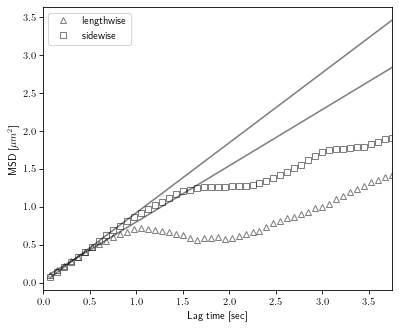

In [142]:
# Perform vector analysis & MSD
# initialize msd
msd_N = []; msd_S1 = []; msd_S2 = []; msd_NR = []
msd_P = []; msd_R = []; msd_Y = []; msd_CM = []
nInterval = 50

# compute 3D exposure time
pxum = 0.115; 
camExposure_ms = 2
sweep_um = 15
stepsize_nm = 400
exp3D_ms = 1e-3 * camExposure_ms * (sweep_um*1e3/stepsize_nm) 

# center-of-mass tracking
nt = len(cm)
dstCM = np.zeros(nt)
for i in range(len(cm)): dstCM[i] = np.linalg.norm(cm[i])

# MSD: mean square displacement

MSD_N, MSD_S1, MSD_S2, MSD_NR = msd.trans_MSD_Namba(nt,
                                          cm, EuAng[:,1],
                                          n1s, n2s, n3s,
                                          exp3D_ms, nInterval)
MSD_P = msd.regMSD(nt, EuAng[:,0], exp3D_ms, nInterval)
MSD_R = msd.regMSD(nt, EuAng[:,1], exp3D_ms, nInterval)
MSD_Y = msd.regMSD(nt, EuAng[:,2], exp3D_ms, nInterval)
MSD_CM = msd.regMSD(nt, dstCM, exp3D_ms, nInterval)

msd_N.append(MSD_N); msd_S1.append(MSD_S1); msd_S2.append(MSD_S2)
msd_NR.append(MSD_NR)
msd_P.append(MSD_P); msd_R.append(MSD_R); msd_Y.append(MSD_Y)
msd_CM.append(MSD_CM)

# Fit MSD with y = Const + B*x for N, S, NR, PY, R
Nfit = 10
xtime = np.linspace(1,Nfit,Nfit)
def MSDfit(x, a, b): return b + a * x  
fit_N,fitN_const  = optimize.curve_fit(MSDfit, xtime, MSD_N[0:Nfit])[0]
fit_S,fitS_const  = optimize.curve_fit(MSDfit, xtime,
                        np.mean([MSD_S1[0:Nfit],MSD_S2[0:Nfit]],axis=0))[0]
fit_NR,fitNR_const = optimize.curve_fit(MSDfit, xtime, MSD_NR[0:Nfit])[0]
fit_PY,fitPY_const = optimize.curve_fit(MSDfit, xtime,
                          np.mean([MSD_P[0:Nfit],MSD_Y[0:Nfit]],axis=0))[0]
fit_R,fitR_const   = optimize.curve_fit(MSDfit, xtime, MSD_R[0:Nfit])[0]
fit_CM,fitCM_const = optimize.curve_fit(MSDfit, xtime, MSD_CM[0:Nfit])[0]

# Additional fit
fit_S1,fitP_const  = optimize.curve_fit(MSDfit, xtime, MSD_S1[0:Nfit])[0]
fit_S2,fitY_const  = optimize.curve_fit(MSDfit, xtime, MSD_S2[0:Nfit])[0]
fit_P, fitP_const  = optimize.curve_fit(MSDfit, xtime, MSD_P[0:Nfit])[0]
fit_Y, fitY_const  = optimize.curve_fit(MSDfit, xtime, MSD_Y[0:Nfit])[0]

# plot MSD and fit
xaxis = np.arange(1,nInterval+1)
fig0,ax0 = plt.subplots(dpi=75, figsize=(6,5))
ax0.plot(xaxis*exp3D_ms,MSD_N,c='k',marker="^",mfc='none',
          ms=5,ls='None',alpha=0.5)   
ax0.plot(xaxis*exp3D_ms,np.mean([MSD_S1,MSD_S2],axis=0),
         c='k',marker="s",mfc='none',
          ms=5,ls='None',alpha=0.5)
ax0.plot(xaxis*exp3D_ms,fitN_const + fit_N*xaxis,
         c='k',alpha=0.5,label='_nolegend_')
ax0.plot(xaxis*exp3D_ms,fitS_const + fit_S*xaxis,
         c='k',alpha=0.5,label='_nolegend_')
ax0.set_xlabel(r'Lag time [sec]');
ax0.set_ylabel(r'MSD [$\mu m^2$]')
# ax0.set_ylim([0, 2]);
ax0.set_xlim([0, nInterval*exp3D_ms])
ax0.legend(["lengthwise","sidewise"])

print(fit_N/(2*exp3D_ms))
print(fit_S/(2*exp3D_ms))
print(fit_N/fit_S)

In [146]:
# Check binarization
viewer = napari.Viewer(ndisplay=3)      
viewer.add_image(stackRaw, contrast_limits=[100,140],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='gray',opacity=0.5)
viewer.add_image(blobBin, contrast_limits=[0,1],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='green',opacity=0.5)
viewer.scale_bar.visible=True
viewer.scale_bar.unit='um'
viewer.scale_bar.position='top_right'
viewer.axes.visible = True
napari.run()

In [17]:
pathZarr[:-4]

'C:\\Users\\labuser\\Dropbox (ASU)\\Research\\DNA-Rotary-Motor\\Helical-nanotubes\\Light-sheet-OPM\\Result-data\\20220227_franky_MT_suc99_20um\\timelapse_2022_02_28-03_03_30\\timelapse_2022_02_28-03_03_30-B'

C:\Users\labuser\miniconda3\envs\AnalysisNew\lib\site-packages\naparimovie\scriptcommands.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  command_list = np.array(command_list)
C:\Users\labuser\miniconda3\envs\AnalysisNew\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


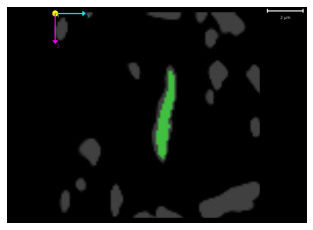

In [147]:
# save movie  
pathMovie = pathZarr[:-4] + '-Time.mov'

from naparimovie import Movie
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(stackRaw, contrast_limits=[100,140],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='gray',opacity=0.5)
viewer.add_image(blobBin, contrast_limits=[0,1],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='green',opacity=0.5)
viewer.scale_bar.visible=True
viewer.scale_bar.unit='um'
viewer.scale_bar.position='top_right'
viewer.axes.visible = True
movie = Movie(myviewer=viewer)
movie.create_state_dict_from_script('../moviecommands/mcTime.txt')
movie.make_movie(pathMovie,fps=10)

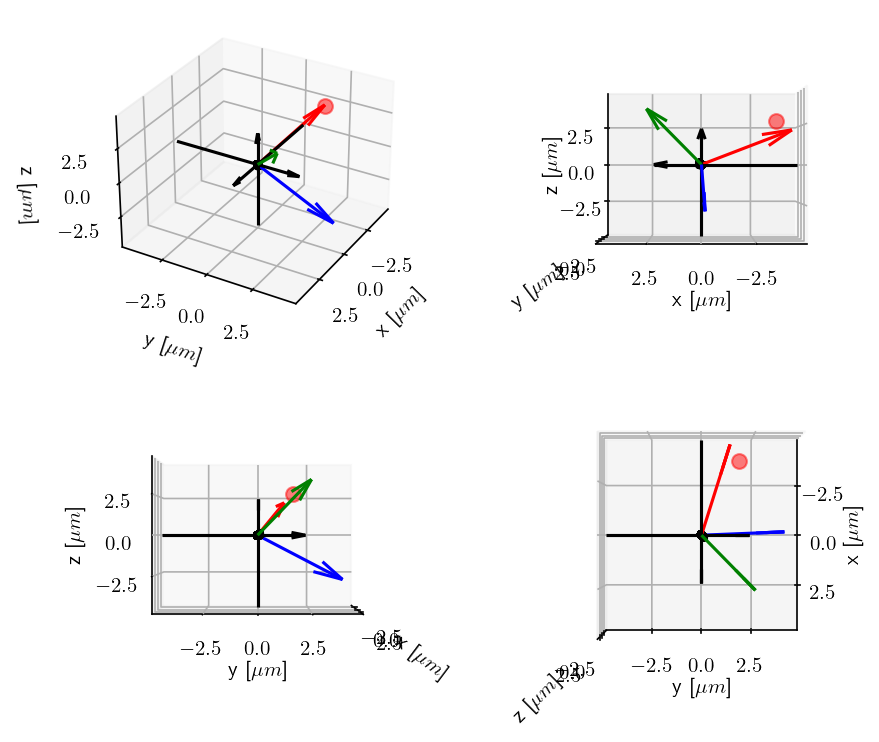

In [105]:
# for frame in range(len(blobBin)):
for frame in range(1):
        
    X0 = np.array(blobBin[frame])
    CM1 = np.array([sum(X0[:,j]) for j in range(X0.shape[1])])/X0.shape[0]
    xb0 = X0 - CM1

    fig = plt.figure(dpi=150, figsize = (7, 6))
#     fig.suptitle('data: %s\n' %ThName +
#                  'frame-num = ' + str(frame).zfill(3) + ', '
#                  'length = %.3f $\mu$m\n' %np.round(lenfla[frame],3) +
#                  '$\Delta_\parallel$ = %.3f $\mu$m, ' %np.round(disp[frame,0],3) +
#                  '$\Delta_{\perp 1}$ = %.3f $\mu$m, ' %np.round(disp[frame,1],3) +
#                  '$\Delta_{\perp 2}$ = %.3f $\mu$m\n' %np.round(disp[frame,2],3) +
#                  '$\Delta_\psi$ = %.3f rad, ' %np.round(EuAng[frame,1],3) +
#                  '$\Delta_\gamma$ = %.3f rad, ' %np.round(EuAng[frame,0],3) +
#                  '$\Delta_\phi$ = %.3f rad\n' %np.round(EuAng[frame,2],3)
#                  )
    ax0 = fig.add_subplot(221,projection='3d')
    ax2 = fig.add_subplot(222,projection='3d')
    ax3 = fig.add_subplot(223,projection='3d')
    ax4 = fig.add_subplot(224,projection='3d')
    pxum = 0.115

    ## plot 1
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax0.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax0.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax0.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax0.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax0.view_init(elev=30, azim=30)
    ax0.set_xlabel(r'x [$\mu m$]'); ax0.set_ylabel(r'y [$\mu m$]')
    ax0.set_zlabel(r'z [$\mu m$]')
    ax0.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax0.scatter(endpt[frame,0]*pxum,\
                endpt[frame,1]*pxum,\
                endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax0.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax0.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax0.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 2
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax2.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax2.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax2.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax2.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax2.view_init(elev=0, azim=90)
    ax2.set_xlabel(r'x [$\mu m$]'); ax2.set_ylabel(r'y [$\mu m$]')
    ax2.set_zlabel(r'z [$\mu m$]')
    ax2.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax2.scatter(endpt[frame,0]*pxum,\
                endpt[frame,1]*pxum,\
                endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax2.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax2.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax2.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 3
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax3.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax3.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax3.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax3.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax3.view_init(elev=0, azim=0)
    ax3.set_xlabel(r'x [$\mu m$]'); ax3.set_ylabel(r'y [$\mu m$]')
    ax3.set_zlabel(r'z [$\mu m$]')
    ax3.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax3.scatter(endpt[frame,0]*pxum,\
               endpt[frame,1]*pxum,\
               endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax3.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax3.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax3.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 4
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax4.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax4.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax4.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax4.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax4.view_init(elev=90, azim=0)
    ax4.set_xlabel(r'x [$\mu m$]'); ax4.set_ylabel(r'y [$\mu m$]')
    ax4.set_zlabel(r'z [$\mu m$]')
    ax4.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax4.scatter(endpt[frame,0]*pxum,\
               endpt[frame,1]*pxum,\
               endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax4.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax4.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax4.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')
    #ax4.figure.savefig(os.path.join(savingFolder, ThName + '-' + 
    #                                str(frame).zfill(3) + '.png'))
#     ax4.show()